# Character-level Text Generation on Harry Potter Books
---
A boredom project of mine, heavily inspired by [Andrej Karpathy's video](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=2156s).
This is a character-level Transformer model trained on the Harry Potter books. The aim of the project for me personally is to try to remember how to use PyTorch and Lightning, and to try to understand the Transformer model better. I trained it on Kaggle's GPU for 5 epochs and it took about 10 hours.

The dataset is taken from [Formcept's Github Repo](https://github.com/formcept/whiteboard/tree/master/nbviewer/notebooks/data/harrypotter).

## Pre-Requisites

### Library imports

In [1]:
# Importing the visualisation and data processing library
import matplotlib.pyplot as plt
import pandas as pd

# Importing Torch and all that good stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

# Importing Lightning and Torchmetrics
import lightning as L
from lightning.pytorch.loggers import CSVLogger
import torchmetrics

### Reading in the dataset

In [2]:
# Reading in the dataset
with open('data//hp_all.txt', 'r', encoding='utf-8') as f:
    data = f.read()

# Display the first 500 characters of the data
print(data[:500])

/ 




THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, 
were proud to say that they were perfectly normal, 
thank you very much. They were the last people you’d 
expect to be involved in anything strange or 
mysterious, because they just didn’t hold with such 
nonsense. 

Mr. Dursley was the director of a firm called 
Grunnings, which made drills. He was a big, beefy 
man with hardly any neck, although he did have a 
very large mustache. Mrs. Dursley was thin and 
blonde 


## Data Preprocessing

### Character maps

In [3]:
# Creating a set of unique characters from the text
unique_chars = sorted(list(set(data)))

# Creating a character map from the text
stoi = {ch:i for i,ch in enumerate(unique_chars)}

# Creating the inverse map
itos = {i:ch for ch,i in stoi.items()}

# Printing the length of the vocabulary and the vocabulary
print("Length of vocabulary : {}".format(len(unique_chars)))
print("Vocabulary : {}".format(unique_chars))

Length of vocabulary : 92
Vocabulary : ['\n', ' ', '!', '"', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '—', '‘', '’', '“', '”', '•', '■', '□']


### Mapper functions

In [4]:
# Creating a lambda function to convert a string to a integer
encode = lambda s: [stoi[c] for c in s]

# Creating a lambda function to convert a integer to a string
decode = lambda i: ''.join([itos[j] for j in i])

### Converting the data into integer values

In [5]:
# Converting the data into int using the encode function
data_encoded = torch.tensor(encode(data), dtype=torch.int32)

# Previewing the first 500 characters
print(data_encoded[:500])

tensor([13,  1,  0,  0,  0,  0,  0, 47, 35, 32,  1, 29, 42, 52,  1, 50, 35, 42,
         1, 39, 36, 49, 32, 31,  1,  0,  0, 40, 73, 12,  1, 56, 69, 59,  1, 40,
        73, 74, 12,  1, 31, 76, 73, 74, 67, 60, 80, 10,  1, 70, 61,  1, 69, 76,
        68, 57, 60, 73,  1, 61, 70, 76, 73, 10,  1, 43, 73, 64, 77, 60, 75,  1,
        31, 73, 64, 77, 60, 10,  1,  0, 78, 60, 73, 60,  1, 71, 73, 70, 76, 59,
         1, 75, 70,  1, 74, 56, 80,  1, 75, 63, 56, 75,  1, 75, 63, 60, 80,  1,
        78, 60, 73, 60,  1, 71, 60, 73, 61, 60, 58, 75, 67, 80,  1, 69, 70, 73,
        68, 56, 67, 10,  1,  0, 75, 63, 56, 69, 66,  1, 80, 70, 76,  1, 77, 60,
        73, 80,  1, 68, 76, 58, 63, 12,  1, 47, 63, 60, 80,  1, 78, 60, 73, 60,
         1, 75, 63, 60,  1, 67, 56, 74, 75,  1, 71, 60, 70, 71, 67, 60,  1, 80,
        70, 76, 86, 59,  1,  0, 60, 79, 71, 60, 58, 75,  1, 75, 70,  1, 57, 60,
         1, 64, 69, 77, 70, 67, 77, 60, 59,  1, 64, 69,  1, 56, 69, 80, 75, 63,
        64, 69, 62,  1, 74, 75, 73, 56, 

In [6]:
# Printing the shape of the dataset
data_size = data_encoded.shape[0]
print("The shape of the dataset is: ", data_size)

The shape of the dataset is:  6765181


### Separating the data into training and validation sets

In [7]:
# Setting a seed for reproducibility
torch.manual_seed(0)

# Separating the data into training and testing sets
train, valid = random_split(data_encoded, [0.9, 0.1])

### Creating a torch dataset class

In [8]:
class MakeDataset(Dataset):
    def __init__(self, data:torch.Tensor, block_size:int=10):
        self.data = data
        self.block_size = block_size

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, index:int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.data[index : index + self.block_size], self.data[index + 1 : index + self.block_size + 1]

In [9]:
# Defining the block size
block_size = 10

# Converting the torch tensor to a dataset
train_dataset = MakeDataset(train, block_size=block_size)

# Converting the valid tensor to a dataset
valid_dataset = MakeDataset(valid, block_size=block_size)

In [10]:
# Empty lists to store inputs and targets
X = list()
Y = list()

# Take an example from the train_dataset
for i, (x, y) in enumerate(train_dataset):
    if i >= 5:
        break
    
    X.append(x.numpy())
    Y.append(y.numpy())

# Print the inputs and targets example
for x, y in zip(X, Y):
    print("input: ", x, "target:", y)
    print('\n')

input:  [69 76 59  1 60  1  0 56  1 64] target: [76 59  1 60  1  0 56  1 64 56]


input:  [76 59  1 60  1  0 56  1 64 56] target: [59  1 60  1  0 56  1 64 56  1]


input:  [59  1 60  1  0 56  1 64 56  1] target: [ 1 60  1  0 56  1 64 56  1 60]


input:  [ 1 60  1  0 56  1 64 56  1 60] target: [60  1  0 56  1 64 56  1 60 70]


input:  [60  1  0 56  1 64 56  1 60 70] target: [ 1  0 56  1 64 56  1 60 70 61]




### Creating DataLoaders

In [11]:
# Defining the batch size
batch_size = 8

# Creating the dataloader for the training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Creating the dataloader for the validation data
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [12]:
# Sampling the data from the DataLoader
for i, (inputs, labels) in enumerate(train_loader):
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([8, 10])
torch.Size([8, 10])


## Defining the Transformer Model

### Single-head attention

In [13]:
class AttentionHead(nn.Module):
    
    def __init__(self, n_embed:int, head_size:int, dropout_rate:float=0.1):
        
        super().__init__()

        # Initialize parameters
        self.n_embed = n_embed
        self.head_size = head_size

        # Query, Key, Value
        self.W_Q = nn.Linear(n_embed, head_size)
        self.W_K = nn.Linear(n_embed, head_size)
        self.W_V = nn.Linear(n_embed, head_size)

        # Masking buffer
        self.register_buffer('mask', torch.tril(torch.ones(head_size, head_size)))

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # Get the shape of the input
        _,T,C = x.shape

        # Get the query, key, and value vectors
        q = self.W_Q(x) 
        k = self.W_K(x) 
        v = self.W_V(x)

        # Masking the attention weights ala Decoder model
        wei = q @ k.transpose(-2,-1) * x.shape[-1]**-0.5 
        wei = wei.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # Matrix multiplication to get the output
        out = wei @ v

        return out

### Multi-head attention

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embed:int, n_head:int, dropout_rate:float=0.1):
        super().__init__()

        # Initialize parameters
        self.head_size = n_embed // n_head
        self.n_head = n_head
        self.n_embed = n_embed
        
        # Initialize the heads
        self.heads = nn.Sequential(*[AttentionHead(n_embed, self.head_size, dropout_rate) for _ in range(n_head)])
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Projection layer
        self.W_O = nn.Linear(n_head * self.head_size, n_embed, bias=False)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        
        x = torch.cat([self.heads[i](x) for i in range(self.n_head)], dim=-1)
        x = self.dropout(x)
        out = self.W_O(x)

        return out

### Feed forward network

In [15]:
class FeedForward(nn.Module):
    def __init__(self, n_embed:int, dropout_rate:float=0.1):
        super().__init__()

        # Implementation of Feedforward model
        self.stack = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.stack(x)

### Transformer hidden layer

In [16]:
class TransformerLayer(nn.Module):
    def __init__(self, n_embed:int, n_head:int, dropout_rate:float=0.1):
        super().__init__()

        # Initialize layers
        self.attention = MultiHeadAttention(n_embed, n_head, dropout_rate)
        self.feed_forward = FeedForward(n_embed, dropout_rate)
        self.layernorm_1 = nn.LayerNorm(n_embed)
        self.layernorm_2 = nn.LayerNorm(n_embed)

    def forward(self, x:torch.Tensor, mask:torch.Tensor=None) -> torch.Tensor:
        x = x + self.attention(self.layernorm_1(x))
        x = x + self.feed_forward(self.layernorm_2(x))
        return x

### Transformer model

In [17]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size:int, n_embed:int, n_heads:int, block_size:int, n_layers:int=4, dropout_rate:float=0.1):
        super().__init__()

        # Embedding layers
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.pos_embedding = nn.Embedding(block_size, n_embed)

        # Initialize the transformer layers
        self.hidden_layers = nn.Sequential(*[TransformerLayer(n_embed, n_heads, dropout_rate) for _ in range(n_layers)])

        # Final projection and normalization
        self.layernorm = nn.LayerNorm(n_embed)
        self.linear = nn.Linear(n_embed, vocab_size)
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.token_embedding(x) + self.pos_embedding(torch.arange(x.shape[1], device=x.device))
        x = self.hidden_layers(x)
        x = self.layernorm(x)
        x = self.linear(x)
        return x

## Lightning Wrappers

### Lightning model

In [18]:
class TransformerLightning(L.LightningModule):
    def __init__(self, model:nn.Module, learning_rate:float, vocab_size:int):
        super().__init__()
        
        # Choosing the hyperparameters
        self.learning_rate = learning_rate
        self.model = model

        # Saving the hyperparameters
        self.save_hyperparameters(ignore=["model"])

        # Torchmetrics logging
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=vocab_size)
        self.valid_acc = torchmetrics.Accuracy(task="multiclass", num_classes=vocab_size)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def _shared_step(self, batch:tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get the input and labels
        features, true_labels = batch

        # Logits from the model
        logits = self(features)

        # Reshapping the label and logits
        B, T, C = logits.shape
        logits = logits.view(B * T, C)
        true_labels = true_labels.view(B * T)

        # Calculating the loss
        loss = F.cross_entropy(logits, true_labels)

        # Getting the label
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch:tuple[torch.Tensor, torch.Tensor], batch_idx:torch.Tensor) -> torch.Tensor:
        # Get the loss, true labels and predicted labels
        loss, true_labels, predicted_labels = self._shared_step(batch)

        # Logging the loss and accuracy
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=True, sync_dist=True)
        return loss

    def validation_step(self, batch:tuple[torch.Tensor, torch.Tensor], batch_idx:torch.Tensor) -> torch.Tensor:
        # Get the loss, true labels and predicted labels
        loss, true_labels, predicted_labels = self._shared_step(batch)

        # Logging the loss and accuracy
        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        self.valid_acc(predicted_labels, true_labels)
        self.log("val_acc", self.valid_acc, prog_bar=True, sync_dist=True)

    def configure_optimizers(self):
        # Configuring the optimizer
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

### Data module

In [19]:
class MakeDM(L.LightningDataModule):
    def __init__(self, data_dir:str='./', batch_size:int=64, block_size:int=10, num_workers:int=0) -> None:
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.block_size = block_size
        self.num_workers = num_workers

    def prepare_data(self) -> None:
        # Loading in the data
        with open(self.data_dir, mode='r', encoding='utf-8') as f:
            self.data_ = f.read()

        # Creating mapping from characters to integers and vice versa
        self.stoi_ = {ch:i for i,ch in enumerate(sorted(list(set(self.data_))))}
        self.itos_ = {i:ch for ch,i in self.stoi_.items()}

    def encode(self, text:str) -> list[int]:
        return [self.stoi_[ch] for ch in text]
    
    def decode(self, encoded:list[int]) -> str:
        return [self.itos_[i] for i in encoded]

    def setup(self, stage:str, seed:bool=True, train_size:float=0.9) -> None:
        # Convert the text into a integer representation
        self.encoded_ = torch.tensor(self.encode(self.data_))
        
        # Convert the data into a dataset
        self.dataset_ = MakeDataset(self.encoded_, block_size=self.block_size)

        # Creating a random generator
        generator = torch.Generator().manual_seed(0) if seed else None
        
        # Split the data into training and validation sets
        self.train_data_, self.valid_data_ = random_split(self.dataset_, lengths=[train_size, 1 - train_size], generator=generator)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_data_, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.valid_data_, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

## Model Training

### Initialisation

In [20]:
# Hyperparameters and settings
data_dir = "data//hp_all.txt"
vocab_size = 92
n_embed = 512
n_heads = 16
block_size = 32
n_layers = 8
dropout_rate = 0.1
num_workers = 2
batch_size = 512
learning_rate = 1e-3

# Creating the model
transformer = TransformerModel(vocab_size, n_embed, n_heads, block_size, n_layers, dropout_rate)

In [21]:
# Creating the data module for lightning
dm = MakeDM(data_dir=data_dir, batch_size=batch_size, 
            num_workers=num_workers, block_size=block_size)

# Preparing the data
dm.prepare_data()

# Creating the model for lightning
lightning_model = TransformerLightning(model=transformer, learning_rate=learning_rate, vocab_size=vocab_size)

### Training the model

In [22]:
# # Creating the training loop
# trainer = L.Trainer(
#     fast_dev_run=1,
#     max_epochs=15,
#     accelerator="cpu" if not torch.cuda.is_available() else "gpu",
#     devices="auto",
#     deterministic=True,
#     logger=CSVLogger("logs/", name="hp-tf"),
#     strategy="ddp_notebook" if torch.cuda.is_available() else None
# )

# # Fitting the model
# trainer.fit(model=lightning_model, datamodule=dm)

### Visualisation of training logs

In [23]:
# Reading the logs from the csv log file
logs = pd.read_csv('logs/hp-tf/metrics.csv')

# Preview the first 5 lines of the loaded data
logs.head()

,train_loss_step,train_acc_step,epoch,step,val_loss,val_acc,train_loss_epoch,train_acc_epoch
0,2.786622,0.260010,0,49,NaN,NaN,NaN,NaN
1,2.408864,0.324463,0,99,NaN,NaN,NaN,NaN
2,2.093794,0.402222,0,149,NaN,NaN,NaN,NaN
3,1.833889,0.466797,0,199,NaN,NaN,NaN,NaN
4,1.675614,0.504974,0,249,NaN,NaN,NaN,NaN


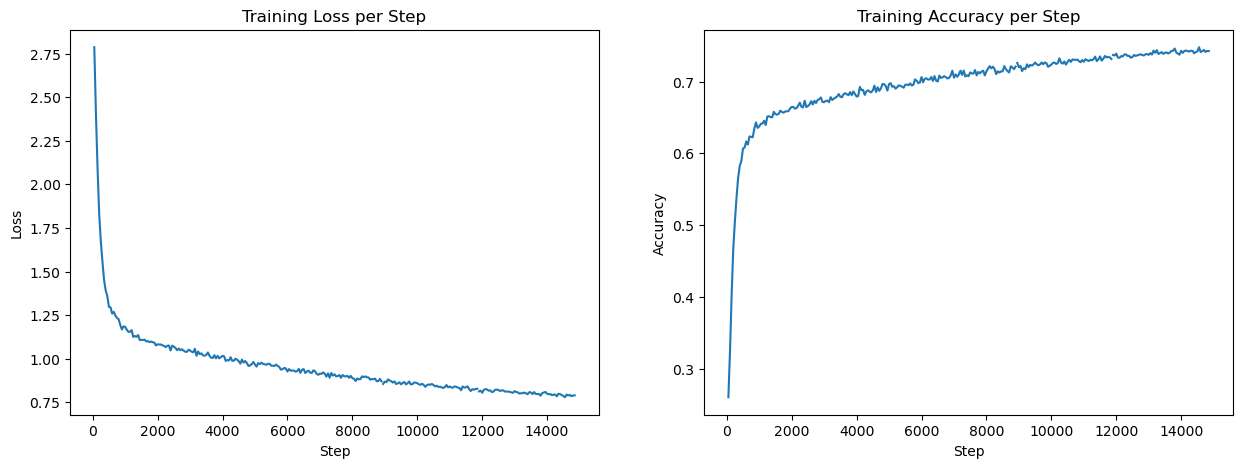

In [24]:
# Setting up two figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting the step losses for the training data
ax1.plot(logs['step'], logs['train_loss_step'])
ax1.set_title('Training Loss per Step')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')

# Plotting the step accuracies for the training data
ax2.plot(logs['step'], logs['train_acc_step'])
ax2.set_title('Training Accuracy per Step')
ax2.set_xlabel('Step')
ax2.set_ylabel('Accuracy')

# Displaying the plots
plt.show()

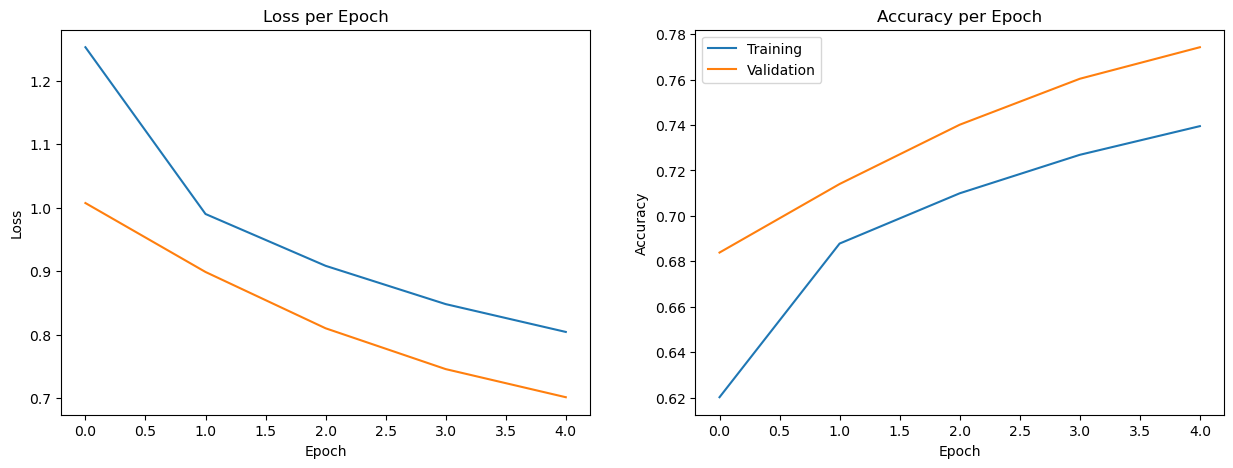

In [25]:
# Groupping the metrics based on epoch
logs_epoch = logs.groupby('epoch').mean()

# Setting up two figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting the Epoch losses for the training data
ax1.plot(logs_epoch['train_loss_epoch'], label='Training')
ax1.plot(logs_epoch['val_loss'], label='Validation')
ax1.set_title('Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plotting the Epoch accuracies for the training data
ax2.plot(logs_epoch['train_acc_epoch'], label='Training')
ax2.plot(logs_epoch['val_acc'], label='Validation')
ax2.set_title('Accuracy per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

# Displaying the plots
plt.legend()
plt.show()

### Saving the model

In [26]:
# # Saving the model weights
# torch.save(transformer.state_dict(), "model//model_weights.pth")

## Inference

### Loading the model back in

In [27]:
# Creating the model
transformer = TransformerModel(vocab_size, n_embed, n_heads, block_size, n_layers, dropout_rate)

# Loading the model in
transformer.load_state_dict(torch.load('model//model_weights.pth'))

# Setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Moving the model to the device
transformer.to(device)

TransformerModel(
  (token_embedding): Embedding(92, 512)
  (pos_embedding): Embedding(32, 512)
  (hidden_layers): Sequential(
    (0): TransformerLayer(
      (attention): MultiHeadAttention(
        (heads): Sequential(
          (0): AttentionHead(
            (W_Q): Linear(in_features=512, out_features=32, bias=True)
            (W_K): Linear(in_features=512, out_features=32, bias=True)
            (W_V): Linear(in_features=512, out_features=32, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): AttentionHead(
            (W_Q): Linear(in_features=512, out_features=32, bias=True)
            (W_K): Linear(in_features=512, out_features=32, bias=True)
            (W_V): Linear(in_features=512, out_features=32, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (2): AttentionHead(
            (W_Q): Linear(in_features=512, out_features=32, bias=True)
            (W_K): Linear(in_features=512, out_features=32, b

### Generating new text

In [28]:
def generate(context:str, model:nn.Module=transformer, max_tokens:int=100, temperature:int=1, 
             block_size:int=32, device:str='cpu', seed:int=None) -> str:
    # Setting the model to evaluation mode
    model.eval()

    # Context string
    context = context

    # Print the context
    print(context, end='')

    # Convert the context to tokens
    context_tokens = torch.Tensor([dm.encode(context[-block_size:])]).long().to(device)

    # Set the random seed
    generator = torch.Generator(device=device).manual_seed(seed) if seed is not None else None

    for _ in range(max_tokens):
        # Generate the next token
        generated = model(context_tokens) * temperature
        
        # Sample a token from the probability distribution
        next_token = torch.multinomial(torch.softmax(generated[:, -1, :], dim=-1), 
                                       num_samples=1, generator=generator).squeeze()

        # Decode the generated token
        decoded = dm.decode([next_token.item()])[0]
        print(decoded, end='')

        # Append the generated token to the context
        context += decoded

        if context_tokens.shape[1] >= block_size:
            # Remove the first token
            context_tokens = context_tokens[:, 1:]

        # Concatenate the generated token and the context tokens
        context_tokens = torch.cat([context_tokens, next_token.view(1, 1)], dim=-1)

    return context

In [29]:
print(generate("Harry, y'er a wizard", model=transformer, max_tokens=1000, temperature=1, seed=0))

Harry, y'er a wizard!” 

She drew out a hand to shoot backward into it, she looked as if 
someone had killed him then?” whispered Harry, 
shaking uncontrollably. 

“Give it a rest, Hermione,” said Tonks, and you are worried, are 
you?” 

“No,” Mr. Weasley muttered. “Well, it ought to be qualified for,” 
before turning back to the Dursleys’ 
house. There was no longer a pay 
raise power, won’t they?” said Hermione curtly. 
“There’s an easier way up at the cat, the small window 
started to spin yet again a little to 
listen to her. He stared guilty at the 
World Cup. 

“You’ve already used it!” he panted, 
mouthing shrilly, and Hagrid rolled over and sat down. 



“I thought this is because it is going to 
sleep with the course of emotion!” she said in a sharp voice from 
behind both of them floating in front of the fire. 

“Go quick, Harry. I’m going to descend 
from behind him and mine froze. Harry 
reached a stocky little Tradea Sorcery and 
everyone thinks you’re taking it down so Ri